

# Clase 5. Modelos Lineales

Empezaremos a ver regresión lineal  
Este capítulo está inspirado en el capítulo 3 y 6 del libro de Introduction to Statistical Learning
 O el capítulo 3 de ESL

# Mínimos Cuadrados Ordinarios (OLS)

* Sean $y_{N \times 1}$, y $X_{N\times (p+1)}$ las variables dependiente y matriz de regresores, respectivamente, donde $X$ incluye $p$ regresores y un vector de unos.


* El modelo lineal es 

$$
\begin{eqnarray}
y &=& X\beta + \epsilon\\
\end{eqnarray}
$$


* El estimador de OLS es el vector $\hat{\beta}$ que minimiza la *suma de residuos al cuadrado* (SSR):

$$
\min_{\beta} SSR(\beta) = (y-X\beta)'(y-X\beta)
$$


* La solución se encuentra fácilmente:
$$
\hat{\beta} = (X'X)^{-1}X'y
$$

y la matriz de varianzas y covarianzas es:

$$
\Sigma_{\beta} = \hat{\sigma}^2(X'X)^{-1}
$$

donde $\hat{\sigma}^2$ es la varianza residual estimada.

# Algunas propiedades del estimador de OLS

*  **Prop 1: El estimador OLS es insesgado**:

$$
E(\hat{\beta}) = \beta
$$

(qué supuestos hay que hacer para probarlo?)

*  **Prop 2: Teorema de Gauss-Markov**:
> El estimador OLS es el estimador de menor varianza, dentro de la clase de estimadores lineales insesgados.

*  **Prop 3: Los residuos estimados son ortogonales a la matriz de regresores:**

$$
X'e = 0
$$



# Selección de variables


* En general no sabemos cuáles variables deben ir incluidas en un análisis, y este problema puede ser importante cuando tenemos muchos regresores $p$.


* Hay varios métodos de selección de variables que permiten:

    1. **Mejorar la predicción:** por ejemplo, porque un estimador tiene poco sesgo pero mucha varianza.
    
    2. **Facilitar la interpretación:** al eliminar ciertas variables podemos concentrarnos únicamente en las más importantes.
    
 
* Hay tres familias de métodos que se pueden utilizar:

    1. Selección de subconjuntos de variables
    
    2. Regularización o reducción de la magnitud de los coeficientes o *shrinkage*
    
    3. Reducción de dimensionalidad




# Selección de subconjuntos: *Best Subset Selection*

* Si tenemos $p$ regresores, queremos estimar las $\binom{p}{k}$ posibles combinaciones de subconjuntos de $k$ variables.


* Es un método exhaustivo que puede ser computacionalmente ineficientes cuando $p$ es grande.


* Veamos cómo funciona este método utilizando los datos de tarjeta de crédito que están disponibles en la página de [ISL](http://www-bcf.usc.edu/~gareth/ISL/data.html).


* Los datos incluyen el saldo en tarjeta de crédito (balance), el ingreso (Income) y límite de crédito  (Limit), score crediticio (Rating), número de tarjetas (Cards), edad, educación, género, variable indicadora del estatus de estudiante del cliente, casado, y etnicidad, para 400 clientes.


* Queremos estimar el efecto que tienen estos regresores sobre el saldo o balance de cada cliente.

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('files/Credit.csv')
data.head(5)

,Income,Limit,Rating,Cards,Age,Education,Own,Student,Married,Region,Balance
0,14.891,3606,283,2,34,11,No,No,Yes,South,333
1,106.025,6645,483,3,82,15,Yes,Yes,Yes,West,903
2,104.593,7075,514,4,71,11,No,No,No,West,580
3,148.924,9504,681,3,36,11,Yes,No,No,West,964
4,55.882,4897,357,2,68,16,No,No,Yes,South,331


In [118]:
# primero organicemos los datos: las variables cuantitativas están bien.  Las cualitativas toca transformarlas
N = data.shape[0]
dum_own     = np.asarray(data.Own == 'Yes').reshape((N,1))
dum_estudiante = np.asarray(data.Student == 'Yes').reshape((N,1))
dum_casado     = np.asarray(data.Married == 'Yes').reshape((N,1))
# Para etnicidad debemos excluir una variable que sirva como referencia:
# tenemos tres categorías: vamos a excluir la tercera: "African American"
print(data.Region.unique())
dum_region = np.asarray(pd.get_dummies(data.Region).iloc[:,:-1])
# etiquetas de X
labs_x = np.array(['Rating','Income','Limit','Cards','Age','Education',
              'Own','Estudiante','Casado','South','West'])
# incluyamos todas las variables:
prexmat = np.concatenate((
                        np.asarray(data.Rating).reshape((N,1)),
                        np.asarray(data.Income).reshape((N,1)),
                         np.asarray(data.Limit).reshape((N,1)),
                         np.asarray(data.Cards).reshape((N,1)),
                         np.asarray(data.Age).reshape((N,1)),
                         np.asarray(data.Education).reshape((N,1)),
                          dum_own, dum_estudiante, dum_casado, dum_region
                         ),axis=1)
saldo = np.asarray(data.Balance).reshape((N,1))
print(prexmat.shape)
# revisemos que todo quedó bien:
pd.DataFrame(prexmat).mean()

['South' 'West' 'East']
(400, 11)


0      354.940000
1       45.218885
2     4735.600000
3        2.957500
4       55.667500
5       13.450000
6        0.517500
7        0.100000
8        0.612500
9        0.247500
10       0.497500
dtype: float64

In [119]:
# Para las posibles combinaciones vamos a usar el módulo itertools
from itertools import combinations
import sys
sys.path.append('/Users/carlos.grandet/Documents/CIDE_DS/Utils')
import olsdan as ols

# probémoslo con conjuntos de 9 elementos
list(combinations(np.arange(10),9))

# vamos a guardar los resultados en un array, pero no se cuántas filas tenemos
res_arr = np.zeros((1,6))
res_arr[:,:] = np.nan
# necesito una lista con todas las combinaciones.  La voy a guardar en un DF
initsub = np.zeros((0,9))
initsub[:] = np.nan
SubSets = pd.DataFrame(initsub)
for k in range(1,12):
    # la siguiente es la lista de todos los regresores posibles para tamaño k
    list_subsets = list(combinations(np.arange(11),k))
    SubSets = SubSets.append(list_subsets)
    # tenemos que hacer un loop sobre todas estas posibilidades:
    for s in range(len(list_subsets)):
        # los regresores seleccionados:
        ind_s = np.array(list_subsets[s])
        xmat_subset = prexmat[:,ind_s]
        # listos para estimar: pero incluyamos constante
        olssk = ols.ols_dan(saldo, np.concatenate((np.ones((N,1)),xmat_subset),axis=1))
        # guardemos los resultados: queremos: número de regresores, ssr
        # Calculemos las medidas que queremos utilizar
        Cp = (1.0/olssk.nobs)*(olssk.ssr() + 2*olssk.nvar*olssk.s2hat())
        AIC = (1.0/(olssk.nobs*olssk.s2hat()))*(olssk.ssr() + 2*olssk.nvar*olssk.s2hat())
        BIC = (1.0/olssk.nobs)*(olssk.ssr() + np.log(olssk.nobs)*olssk.nvar*olssk.s2hat())
        R2bar = olssk.R2_bar()
        prelist = np.array([k, olssk.ssr()[0][0], Cp[0,0], AIC[0,0], BIC[0,0], R2bar]).reshape((1,6))
        # listos para anexar:
        res_arr = np.concatenate((res_arr, prelist),axis=0)
res_arr = pd.DataFrame(res_arr, columns=['k', 'SSR', 'Cp', 'AIC', 'BIC', 'R2bar'])
res_arr.dropna(inplace=True)
res_arr.set_index(np.arange(res_arr.shape[0]), inplace=True)
print(res_arr.shape)

(2047, 6)


In [120]:
res_arr

,k,SSR,Cp,AIC,BIC,R2bar
0,1.0,2.143512e+07,54126.375987,1.0050,55201.219325,1.000000
1,1.0,6.620874e+07,167185.397571,1.0050,170505.370642,1.000000
2,1.0,2.171566e+07,54834.761162,1.0050,55923.671635,1.000000
3,1.0,8.370950e+07,211376.994602,1.0050,215574.525846,1.000235
4,1.0,8.433963e+07,212968.155832,1.0050,217197.284408,1.000321
...,...,...,...,...,...,...
2042,10.0,3.949432e+06,10431.984242,1.0275,11546.407229,1.000107
2043,10.0,4.117780e+06,10876.656400,1.0275,12038.582611,1.000106
2044,10.0,1.461789e+07,38611.527990,1.0275,42736.301703,1.000009
2045,10.0,3.839044e+06,10140.405169,1.0275,11223.679487,1.000057


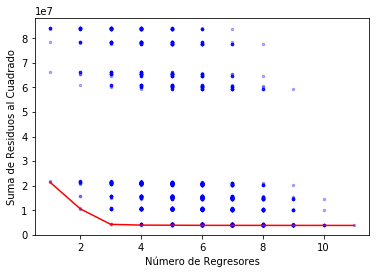

In [121]:
# Ya tenemos todos los modelos:
# Hagamos un gráfico:
plt.scatter(res_arr.k,res_arr.SSR, s=6, color='b',alpha=0.3)
plt.ylabel('Suma de Residuos al Cuadrado')
plt.xlabel(u'Número de Regresores')
# Encontremos la frontera: como en el libro:
front_ssr = res_arr.SSR.groupby(res_arr.k).min()
plt.plot(front_ssr.index, front_ssr.values, color='r')                          

In [122]:
front_ssr

k
1.0     2.143512e+07
2.0     1.053254e+07
3.0     4.227219e+06
4.0     3.915058e+06
5.0     3.866091e+06
6.0     3.821620e+06
7.0     3.810759e+06
8.0     3.800969e+06
9.0     3.794145e+06
10.0    3.789709e+06
11.0    3.786730e+06
Name: SSR, dtype: float64

# ¿Qué variables están incluidas en los mejores modelos?

* Rating

* Ingreso

* Límite de Crédito

* Número de tarjetas

* Dummy Estudiante

In [123]:
res_arr.SSR.values

array([21435122.03273295, 66208744.51078422, 21715656.6591137 , ...,
       14617892.34856283,  3839043.90323933,  3786730.19067778])

In [124]:
np.isin(res_arr.SSR.values,front_ssr.values)

array([ True, False, False, ..., False, False,  True])

In [125]:
# Teníamos unos índices equivocados.  Vamos a hacerlo de 0 a M (M es el número total de modelos o combinaciones)
SubSets.set_index(np.arange(SubSets.shape[0]), inplace=True)
# Get the regressors that were selected:
ind_best = np.isin(res_arr.SSR.values,front_ssr.values)
# teniendo los índices podemos encontrar: los 10 mejores
ind_best = res_arr.index[ind_best]
ind_subset = np.in1d(SubSets.index,ind_best)
SubSets.loc[ind_best]
for i in range(SubSets.loc[ind_best].shape[0]):
    preind = SubSets.loc[ind_best].iloc[i,:]
    #print preind
    preind = np.asarray(pd.Series(preind).dropna(), dtype='int')
    print(labs_x[preind])

['Rating']
['Rating' 'Income']
['Rating' 'Income' 'Estudiante']
['Income' 'Limit' 'Cards' 'Estudiante']
['Rating' 'Income' 'Limit' 'Cards' 'Estudiante']
['Rating' 'Income' 'Limit' 'Cards' 'Age' 'Estudiante']
['Rating' 'Income' 'Limit' 'Cards' 'Age' 'Own' 'Estudiante']
['Rating' 'Income' 'Limit' 'Cards' 'Age' 'Own' 'Estudiante' 'South']
['Rating' 'Income' 'Limit' 'Cards' 'Age' 'Own' 'Estudiante' 'Casado'
 'South']
['Rating' 'Income' 'Limit' 'Cards' 'Age' 'Education' 'Own' 'Estudiante'
 'Casado' 'South']
['Rating' 'Income' 'Limit' 'Cards' 'Age' 'Education' 'Own' 'Estudiante'
 'Casado' 'South' 'West']


# Cómo seleccionamos el mejor modelo?

* Una vez tenemos la frontera, podemos utilizar cuatro opciones para seleccionar:

    1. **Cross-Validation**: minimizar el SSR promedio.
    
    2. Minimizar el Criterio de Información de Akaike:
    $$
    AIC = \frac{1}{n}(RSS + 2d \hat{\sigma}_2)
    $$
    3. Minimizar el Criterio de Información de Bayesiano:
    $$
    BIC = \frac{1}{n}(RSS + \ln(n)d \hat{\sigma}_2)
    $$
    4. Maximizar el $\overline{R}^2$


* La ventaja de los últimos tres criterios es que no necesitamos utilizar muestras de validación: los criterios penalizan el uso indebido de regresores adicionales.

    * Esto es importante: para obtener los últimos tres criterios **no** necesitamos hacer validación cruzada: lo podemos hacer directamente en la muestra de entrenamiento.

# 1. Seleccionando el mejor modelo: Cross-Validation

* El proceso de validación cruzada es simple:

    1. Tenemos identificados los mejores 9 modelos, i.e. los modelos sobre la frontera roja en el gráfico de arriba.
        
        * Cada modelo $\mathcal{M}_k$, identifica la mejor combinación de $k$ regresores en términos de SSR.        
        
    2. Vamos a hacer 10-fold CV: 
        * Dividimos la muestra en 10 grupos iguales.
        * Vamos a iterar el proceso haciendo un loop sobre $1,2,\cdots,10$, donde en cada iteración $g$, la muestra de entrenamiento excluye al grupo $g$, que es utilizado como grupo de validación.
        * Para cada modelo $\mathcal{M}_k$, estimamos los coeficientes de OLS utilizando los 9 grupos de entrenamiento correspondientes.
        * Con estos coeficientes, obtenemos el `SSR` de la muestra de validación correspondiente y lo guardamos.
        * Así, terminamos con una matriz de tamaño $10 \times 10$, donde las filas denotan el modelo, el grupo excluído en la muestra de entrenamiento.
        
* **En la tarea voy a dejar que lo programen ustedes mismos**   

![caption](figures/credit_10fcv.png)


# Miremos los resultados con otros dos criterios: $BIC$ y $\bar{R}^2$
![caption](figures/bicr2bar.png)

# Forward Stepwise Selection


* *Best Subset Selection* es intensivo en poder computacional: necesitamos estimar modelos para **todas** las combinaciones de regresores.

* En el ejemplo anterior, con sólo 10 regresores tuvimos que hacer 2047 estimaciones.

* Una alternativa más eficiente consiste en utilizar un método *bottom-up*:

    * Empezamos con el modelo con una constante.
    
    * Vamos incluyendo regresores de manera iterativa.
    
        * El criterio es seleccionar el regresor que minimiza el SSR en esa iteración.
    
    * Para seleccionar el mejor modelo *global* (tenemos tantos modelos como regresores) utilizamos CV o cualquiera de los otros criterios de selección vistos anteriormente.
    

In [126]:
prexmat

array([[2.83000e+02, 1.48910e+01, 3.60600e+03, ..., 1.00000e+00,
        0.00000e+00, 1.00000e+00],
       [4.83000e+02, 1.06025e+02, 6.64500e+03, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       [5.14000e+02, 1.04593e+02, 7.07500e+03, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [3.21000e+02, 5.78720e+01, 4.17100e+03, ..., 1.00000e+00,
        0.00000e+00, 1.00000e+00],
       [1.92000e+02, 3.77280e+01, 2.52500e+03, ..., 1.00000e+00,
        0.00000e+00, 1.00000e+00],
       [4.15000e+02, 1.87010e+01, 5.52400e+03, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]])

In [127]:
import sys
sys.path.append('/Users/carlos.grandet/Documents/CIDE_DS/Utils')
import olsdan as ols
# forward step-wise selection
# inicialicemos la iteración con una constante
xmat_fss = np.ones((N,1))
# primera iteración: tenemos que seleccionar P modelos
nvar = prexmat.shape[1]
SSRfss = np.zeros((nvar,2))
# una lista donde vamos a guardar los regresores:
reg_opt = []
for k in range(nvar):
    # para cada modelo tenemos que iterar sobre los regresores que quedan:
    # seleccionemos los que quedan:
    ind_quedan = np.setdiff1d(np.arange(nvar),np.array(reg_opt))
    # estamos listos para seleccionar el mejor modelo
    nvar_quedan = ind_quedan.shape[0]
    SSRmat = np.zeros((nvar_quedan,2))
    counter = 0
    for p in ind_quedan:
        # tenemos que utilizar los X previamente seleccionados
        newx = np.concatenate((xmat_fss, prexmat[:,p].reshape((N,1))),axis=1)
        # podemos estimar:
        olsp = ols.ols_dan(saldo,newx)
        SSRmat[counter,:] = [p,olsp.ssr()[0,0]]
        counter +=1
    # terminamos el loop
    # tenemos que seleccionar el regresor actual que minimiza SSRMat
    row_min = np.argmin(SSRmat[:,1],axis=0)
    ssr_min = SSRmat[row_min,1]
    var_min = SSRmat[row_min,0]
    # guardemos esta información
    SSRfss[k,:] = [var_min,ssr_min]
    # finalmente, actualicemos la matriz
    xmat_fss = np.concatenate((xmat_fss,prexmat[:,int(var_min)].reshape((N,1))),axis=1)
    reg_opt.append(int(var_min))

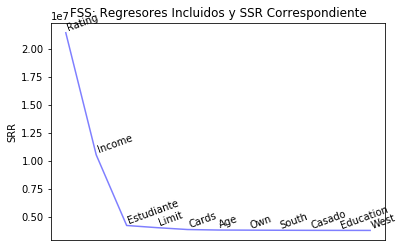

In [128]:
plt.plot(np.arange(1,12), SSRfss[:,1], color='b',alpha=0.5)
for p in range(11):
    plt.text(p+1,SSRfss[p,1],labs_x[int(SSRfss[p,0])], rotation=20,
                verticalalignment='bottom', horizontalalignment='left')
# los ticks en x no dicen nada ahora que incluimos las ettiquetas
plt.xticks([])
plt.title('FSS: Regresores Incluidos y SSR Correspondiente')
plt.ylabel('SRR')
plt.show()


# Backward Stepwise Selection

* Este método es parecido, pero opera de arriba hacia abajo o *top-down*


* Empezamos con un modelo que incluye **todos** los regresores.


* Vamos excluyendo regresores así:

    * En cada iteración nos quedan $k$ regresores.
    
    * Seleccionamos el modelo con $k-1$ regresores (excluyendo una variable) que tiene el menor SSR.
    

* De los $P$ modelos posibles, seleccionamos el mejor modelo global con CV o cualquiera de los otros métodos.

![caption](figures/bss_credit.png)

# Componentes Principales (PCA):

* Una alternativa bastante utilizada en econometría es seleccionar sólo un subconjunto de *combinaciones lineales* de los regresores, y en particular, aquella que tenga un poder de síntesis sobre la matrix $X$ completa lo suficientemente grande.


* En series de tiempo, por ejemplo, cuando tenemos numerosas variables endógenas en un vector autoregresivo o VAR, es fácil agotar los grados de libertad rápidamente si intentamos incluir una dinámica flexible, es decir, un orden de autoregresión que incluya $2,3,4,5, etc.$ rezagos de *todas* las variables endógenas.


* Ver por ejemplo la literatura sobre **Factor Augmented Vector Autoregressive Regression (FAVAR)**.
  
  
* La pregunta que queremos responder es simple:

    > ¿Dada la matriz $X_{N \times {p+1}}$, podemos reducir la dimensionalidad de $X$ sin perder poder explicativo?


* A diferencia de los métodos anteriores donde la *reducción de dimensionalidad* se obtiene *excluyendo* regresores, en PCA se obtiene mediante una selección inteligente de combinaciones lineales de los regresores.


* Así, la primera combinación lineal que utilicemos será la que explique un mayor porcentaje de la varianza de $X$, la siguiente la que explique el segundo mayor porcentaje de la varianza de $X$, y así sucesivamente.

# Componentes Principales (cont):

* Antes de empezar, es común, **centrar** la matriz de regresores, así que, abusando un poco de la notación, sea $X$ una matriz de tamaño $N \times p$, donde cada regresor $x_k$ ha sido centrado, es decir, $x_k- \overline{x}_k$.

    * También es importante centrar la variable dependiente, $y$.  Por esto excluimos la constante.
    
    
* La intuición de los componentes principales se puede obtener muy rápidamente así.


* Supongamos que tenemos $p$  variables aleatorias.

    * Nota 1: la matriz $X$ centrada, recoge las $N$ realizaciones de estas variables aleatorias.
    
    * Nota 2: $N^{-1}X'X$ es la matriz de covarianzas muestral, contraparte de $\Sigma$.
    

* Nuestro objetivo es encontrar un vector $\alpha_j = [\alpha_{1j}, \alpha_{2j}, \cdots, \alpha_{pj}]$ tal que 
$$
\sum_{k=1}^p \alpha_{kj} x_{kj} = \mathbf{\alpha}_j' x
$$

tenga la *mayor varianza posible*.

* Como 

$$
Var(\mathbf{\alpha}_j' x) = \mathbf{\alpha}_j' \mathbf{\Sigma} \mathbf{\alpha}_j
$$

sabemos que podemos elegir $\mathbf{\alpha}_j$ cada vez más grande, así que el problema está indeterminado, a menos que impongamos una normalización: $\mathbf{\alpha}_j'\mathbf{\alpha}_j = 1$.

# Componentes Principales (cont.)


* El problema de optimización que queremos resolver es:

$$
max_{\mathbf{\alpha}_j} \hspace{2mm} \mathcal{L} = \mathbf{\alpha}_j' \mathbf{\Sigma} \mathbf{\alpha}_j - \lambda(\mathbf{\alpha}_j'\mathbf{\alpha}_j - 1)
$$

* Diferenciando, tenemos las condiciones de primer orden:

$$
\begin{eqnarray*}
\mathbf{\Sigma} \mathbf{\alpha}_j &=& \lambda \mathbf{\alpha}_j \\
\mathbf{\alpha}_j'\mathbf{\alpha}_j &=& 1
\end{eqnarray*}
$$

así que podemos reconocer que $\mathbf{\alpha}_j$ es un **vector propio de $\Sigma$**, y $\lambda$ el valor propio correspondiente.


* Pero cuál vector propio?


* Queremos maximizar 
$$
\mathbf{\alpha}_j' \mathbf{\Sigma} \mathbf{\alpha}_j = \mathbf{\alpha}_j' \lambda \mathbf{\alpha}_j = \lambda \mathbf{\alpha}_j' \mathbf{\alpha}_j
$$ 
(¿por qué?)

así que la selección es simple: queremos el vector propio $\mathbf{\alpha}_j$ que corresponda al **mayor** valor propio $\lambda$.


* Este es el **primer componente principal**: $x'\mathbf{\alpha}_j$


* Se puede demostrar que el segundo componente principal es la proyección de $X$ utilizando el vector propio correspondiente al segundo mayor valor propio, y así sucesivamente.


* Así, los componentes principales se obtienen como el producto de $XV$, donde $V$ es la matriz que tiene los vectores propios correspondientes.

# Resumen del procedimiento:

* Paso 1. Centrar la matriz $X$.

* Paso 2. Obtener los primeros $k$ vectores propios de $X'X$, $k \in  \{1,2,\cdots, p\}$, con la convención que  $\lambda_1> \lambda_2 > \cdots > \lambda_p$:

$$
Z_k = XV_k
$$

* Paso 3. Hacer una regresión de

$$
y = Z_k \theta + \epsilon
$$

* Paso 4. Guardar el SSR_k y seleccionar el número óptimo por medio de validación cruzada.

[-1.44773082e-15  4.61852778e-16]


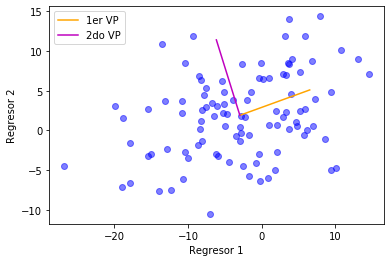

In [129]:
#------------------------------
# Ejemplo con dos regresores:
#------------------------------
# vamos a simular dos regresores correlacionados
np.random.seed(421091725)
N = 100
mu = np.array([-3,2])
W  = np.random.randn(2,2)
DD = np.diag(np.array([10,5]))
Sigma = np.dot(W.T,np.dot(DD,W))
xmat = np.random.multivariate_normal(mu,Sigma,N)

# Paso 1: centrar (usemos broadcasting para facilitar)
xmat_dem = xmat - xmat.mean(axis=0).reshape((1,2))
# probemos que quedó bien hecho
print(xmat_dem.mean(axis=0))

# Paso 2: obtengamos los vectores y valores propios
Smat = (1.0/N)*np.dot(xmat_dem.T,xmat_dem)
D, V = np.linalg.eig(Smat)

# Grafiquémoslos
plt.scatter(xmat[:,0],xmat[:,1], color='b', alpha=0.5)
plt.xlabel('Regresor 1')
plt.ylabel('Regresor 2')
x1bar = xmat.mean(axis=0)[0]
x2bar = xmat.mean(axis=0)[1]
newV = 10*V
plt.plot([x1bar,x1bar + newV[0,0]], [x2bar,x2bar + newV[1,0]], color='orange', label='1er VP')
plt.plot([x1bar,x1bar + newV[0,1]], [x2bar,x2bar + newV[1,1]], color='m', label='2do VP')
plt.legend(loc='best')

# Componentes Principales :


* Los componentes principales son ortogonales entre sí:

    * Los vectores propios lo son.
    
* El primer componente principal busca la dirección de máxima varianza.

* Para obtener la proporción de la varianza de $X$ explicada por el componente principal $k$:

$$
\frac{\lambda_k}{\sum_j \lambda_j}
$$

2.501110429875553e-13


Text(0, 0.5, '% Varianza Explicada')

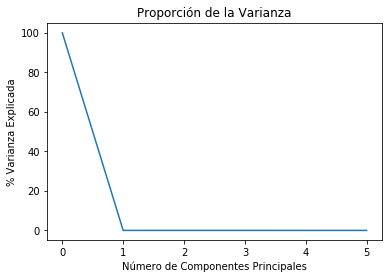

In [130]:
# Volvamos al ejemplo de datos de Crédito
N = data.shape[0]
# Hay dos tipos de variables: continuas y categóricas
prexmat_con = np.concatenate((
                        np.asarray(data.Rating).reshape((N,1)),
                        np.asarray(data.Income).reshape((N,1)),
                         np.asarray(data.Limit).reshape((N,1)),
                         np.asarray(data.Cards).reshape((N,1)),
                         np.asarray(data.Age).reshape((N,1)),
                         np.asarray(data.Education).reshape((N,1)),
                         ),axis=1)
prexmat_cat = np.concatenate((
                          dum_hombre, dum_estudiante, dum_casado, dum_ethnic
                         ),axis=1)
saldo = np.asarray(data.Balance).reshape((N,1))
nvar_con = prexmat_con.shape[1]

# Paso 1: Centrar la matriz de variables continuas
prexmatcon_dem = prexmat_con - np.nanmean(prexmat_con, axis=0).reshape((1,nvar_con))
# check
print(prexmatcon_dem.mean(axis=0).max())

# Paso 2: Eigenvalue decomposition
D,V = np.linalg.eig(np.dot(prexmatcon_dem.T, prexmatcon_dem))

# Paso 3: Construcción de los componentes principales:
# Organicémoslos de menor a mayor: NO SIEMPRE LO ESTAN
D = pd.DataFrame(D, columns=['valores_ppios']).sort_values(by='valores_ppios', ascending=False)
ind_sorted = D.index
# Componentes principales: con los valores propios ordenados de mayor a menor
Zmat = np.dot(prexmatcon_dem,V[:,ind_sorted])
# Veamos la proporción de las varianzas explicadas por todos
plt.plot((100*D/D.sum()).values)
plt.title(u'Proporción de la Varianza')
plt.xlabel(u'Número de Componentes Principales')
plt.ylabel('% Varianza Explicada')

1     37
2     39
3     35
4     42
5     39
6     45
7     40
8     38
9     56
10    29
dtype: int64


Text(0, 0.5, 'SSR Promedio en Grupos de VC')

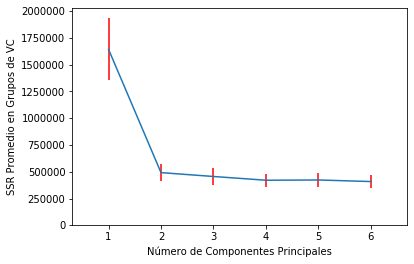

In [131]:
# Vamos a hacer CV con 10 grupos:
grp_cv = 10
ind_grp = np.dot(np.random.multinomial(1,[1.0/grp_cv]*grp_cv, N),np.arange(1,grp_cv+1).reshape(grp_cv,1))
# check:
check = pd.Series(ind_grp.flatten()).groupby(pd.Series(ind_grp.flatten())).count()
print(check)
# Inicialicemos matriz donde vamos a guardar los resultados:
SSRCP = np.zeros((grp_cv,nvar_con))
# centremos y, así no tenemos que incluir constante
saldo_cen = saldo - np.nanmean(saldo,axis=0)
# loop externo: grupos
for g in np.arange(grp_cv):
    ind_train = (ind_grp!=g+1)
    n_train   = ind_train.sum()
    ind_valid = (ind_grp==g+1)
    n_valid   = ind_valid.sum()
    # asignemos variables:
    yy_train  = saldo_cen[ind_train].reshape((n_train,1))
    yy_valid  = saldo_cen[ind_valid].reshape((n_valid,1))
    zz_train  = Zmat[ind_train.flatten(),:]
    zz_valid  = Zmat[ind_valid.flatten(),:]
    dd_train  = prexmat_cat[ind_train.flatten(),:]
    dd_valid  = prexmat_cat[ind_valid.flatten(),:]
    # loop interno: modelos (número de CP)
    for k in range(nvar_con):
        # Necesitamos incluir variables categóricas y los componentes principales
        fullxmat_train = np.concatenate((zz_train[:,:k+1],dd_train),axis=1)
        fullxmat_valid = np.concatenate((zz_valid[:,:k+1],dd_valid),axis=1)
        full_nvar = fullxmat_valid.shape[1]
        olsk = ols.ols_dan(yy_train,fullxmat_train)
        # necesitamos el SSR evaluado en valid
        yhat_valid = np.dot(fullxmat_valid,olsk.betahat().reshape((full_nvar,1)))
        res_valid  = yy_valid - yhat_valid
        SSRCP[g,k] = np.dot(res_valid.T,res_valid)
        

mean_ssr = pd.DataFrame(SSRCP).mean()
sem_ssr  = pd.DataFrame(SSRCP).sem()
plt.plot(np.arange(1,nvar_con+1), mean_ssr.values)
plt.bar(np.arange(1,nvar_con+1), mean_ssr.values, ec='w', fc='w', align='center',
                    yerr = 1.96*sem_ssr.values, ecolor='r')
plt.xlabel(u'Número de Componentes Principales')
plt.ylabel(u'SSR Promedio en Grupos de VC')

# Regularización

En este notebook vamos a estudiar como la regularización puede ayudarnos a reducir los efectos del bias y la varianza. En concreto veremos como utilizar regularización en modelos de regresión.



Todos los modelos de regresión lineal aprenden una serie de *coeficientes* (también llamados parámetros o pesos) y un *intercept* para realizar una combinación lineal de las características del modelo a aprender. Así tenemos que:

```
y_pred = x_test[0] * coef_[0] + ... + x_test[n_features-1] * coef_[n_features-1] + intercept_
```

Existen varios modelos de regresión lineal cuya principal diferencia reside en las restricciones que le ponemos en los *coeficientes*. Recordad que estas restricciones se conocen como regularización.

Vamos a generar una conjunto de datos sintético que nos permita ver el comportamiento de estos modelos.

In [132]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y, true_coefficient = make_regression(n_samples=200, n_features=30,
                                         n_informative=10, noise=100,
                                         coef=True, random_state=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5, train_size=60)

print(X_train.shape)
print(y_train.shape)

(60, 30)
(60,)



## Linear Regression

El modelo lineal más famoso es la regresión OLS (Ordinary Least Squares), llamada *regresión lineal*. Este tipo de regresión no impone ninguna restricción a los coeficientes. Esto significa que cuando tenemos un gran número de caracterísiticas, el modelo tienda a sobreajustar.

$$ \text{min}_{w, b} \sum_i || w^\mathsf{T}x_i + b  - y_i||^2 $$

In [133]:
from sklearn.linear_model import LinearRegression
linear_regression = LinearRegression().fit(X_train, y_train)

In [134]:
print("R^2 on training set: %f" % linear_regression.score(X_train, y_train))
print("R^2 on test set: %f" % linear_regression.score(X_test, y_test))

R^2 on training set: 0.878011
R^2 on test set: 0.216332




Como vemos el $R^2$ en el conjunto de entrenamiento es muy alto, pero muy bajo en el conjunto de test. Esto suele ser un indicativo de que nuestro modelo está sobreajustando.

Vamos a aprovecharnos que nuestros datos son sinténticos para evaluar como se comporta el modelo real sobre los datos:

In [135]:
from sklearn.metrics import r2_score
print(r2_score(np.dot(X, true_coefficient), y))

0.5985284495875146


Por lo que podemos decir que un 𝑅2≈0.6 es un resultado ideal para nuestro conjunto de datos.

También vamos a aprovechar que tenemos conjuntos de datos sinténticos para comparar los coeficientes del aprendidos por el modelo con los coeficientes reales de nuestros datos sinténticos:

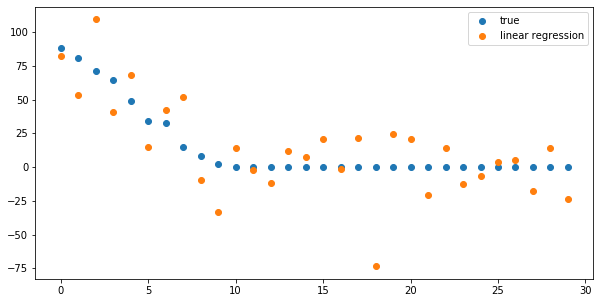

In [136]:
plt.figure(figsize=(10, 5))
coefficient_sorting = np.argsort(true_coefficient)[::-1]
plt.plot(true_coefficient[coefficient_sorting], "o", label="true")
plt.plot(linear_regression.coef_[coefficient_sorting], "o", label="linear regression")

plt.legend()

Un método muy útil para conocer si nuestro modelo sufre de underfitting o de overfitting es calcular las curvas de aprendizaje. Éstas muestran el score del modelo en los conjuntos de training y de test para un número determinado de muestras de entrenamiento.

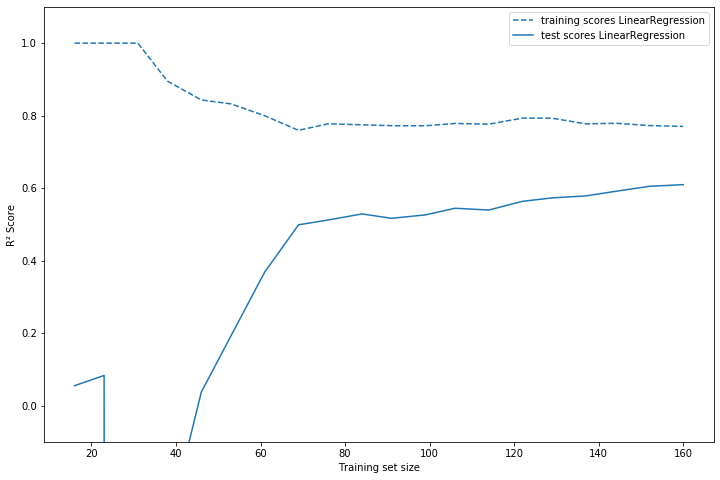

In [137]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(est, X, y):
    training_set_size, train_scores, test_scores = learning_curve(est, X, y, train_sizes=np.linspace(.1, 1, 20))
    estimator_name = est.__class__.__name__
    line = plt.plot(training_set_size, train_scores.mean(axis=1), '--', label="training scores " + estimator_name)
    plt.plot(training_set_size, test_scores.mean(axis=1), '-', label="test scores " + estimator_name, c=line[0].get_color())
    plt.xlabel('Training set size')
    plt.ylabel('R² Score')
    plt.legend(loc='best')
    plt.ylim(-0.1, 1.1)

plt.figure(figsize=(12,8))    
plot_learning_curve(LinearRegression(), X, y)

# Ridge Regression

* Excluyendo la regresión por componentes principales, los métodos anteriores son discontinuos o *sparse*, en el sentido que de los $P$ regresores, sólo excluimos una parte de ellos.
    
    * Los coeficientes $\hat{\beta}_k$ son cero o distintos de cero.
    
* Tiene la ventaja que facilita la interpretación.

* Pero las predicciones pueden tener mucha varianza: incluimos o excluimos regresores.

* Una alternativa es buscar un procedimiento más *suave*, en donde minimicemos el valor absoluto de los coeficientes, sin llevarlos a cero.

* Esto se puede plantear fácilmente en un modelo de optimización donde penalizamos los coeficientes grandes.

$$
\beta_{ridge} = argmin_{\beta} (y - X\beta)'(y - X\beta) + \lambda \beta'\beta
$$

* Derivando, se puede ver que la solución a este problema es:

$$
\beta_{ridge} = (X'X + \lambda I)^{-1}X'y
$$

* **Nota**: **estas fórmulas asumen que el modelo se ha estandarizado, es decir, todas las variables, $y$ ha sido centrada y $x$ estandarizadas, así que excluimos la constante de la estimación.** 

# Ridge Regression: ¿cómo se estima?


* La ecuación de arriba muestra que estimar el método de Ridge Regression es inmediato.


* Para cada valor de $\lambda$, podemos estimar $\beta_{ridge}$.


* Así, si $\lambda = 0$ obtenemos el estimador de OLS.


* A medida que aumentamos $\lambda$ penalizamos más los coeficientes, y los empezamos a reducir.


* **Pregunta:** ¿Por qué quisiéramos hacer eso?


* **Respuesta:** Trade-off entre varianza y sesgo.

> *Reducir ciertos coeficientes suaviza las predicciones en muestras distintas, así que el error de predicción puede tener menor varianza*

# Ridge Regression y Cross-Validation


* Para cada valor $\lambda$ tenemos unos coeficientes $\beta_{ridge}(\lambda)$.


* ¿Cuál valor escogemos?


* La respuesta es simple: dejemos que los datos nos lo digan utilizando CV


# Descomposición en Valores Singulares


* Una pregunta es por qué puede funcionar un método como este.


* Para entender necesitamos introducir una descomposición matricial que es muy utilizada en estadística.


* Toda matriz $X_{N\times p}$ puede descomponerse en el producto de tres matrices:

$$
X = U_{N \times p} D_{p \times p} V_{p \times p}'
$$

donde las columnas de $\mathbf{U}$ son una base ortonormal del espacio de *columnas* de $\mathbf{X}$, y las columnas de $\mathbf{V}$ una base ortonormal del espacio de *filas* de $\mathbf{X}$:

$$
U'U = I_{p} \\
V'V = I_{p}
$$

y $\mathbf{D}$ es una matriz diagonal con $d_{ii}$ los valores singulares de $\mathbf{X}$.


* Así, el $y$ estimado de OLS se puee escribir como

$$
\begin{eqnarray*}
X\hat{\beta} &=& X(X'X)^{-1}X'y \\
&=& (UDV)(VDU'UDV')^{-1} (VDU') y \\
&=& UU'y
\end{eqnarray*}
$$

(¿por qué?)

# Valores Singulares: ¿qué pasa en el caso de Ridge Regression?


* Repitamos para el estimador de *Ridge*

$$
\begin{eqnarray*}
X \beta_{ridge} &=& X(X'X + \lambda I_p)^{-1}X'y \\
&=& (UDV)(VD^2V' + \lambda I_p)^{-1} (VDU') y \\
&=& (UDV)(V(D^2 + \lambda I_p) V')^{-1} (VDU') y \\
&=& UD(D^2 + \lambda I_p)^{-1}DU'y \\
&=& \sum_i \mathbf{u_i} \left(\frac{d_i^2}{d_i^2 + \lambda}\right) \mathbf{u_i}'  y
\end{eqnarray*}
$$


* ¿Qué pasa cuando $\lambda=0$?


* Sabemos que estamos en el caso de OLS (compárenlo con el resultado de la diapósitiva anterior).


* Cuando $\lambda \neq 0$, el estimador reduce las coordenadas de $y$ en el espacio de la base ortonormal $\mathcal{U}$, y lo hace por un factor 

$$
\frac{d_i^2}{d_i^2 + \lambda}
$$


* La reducción es *mayor* a medida que $d_i^2$ es más chico (lámina siguiente)

Text(0, 0.5, 'Shrinkage')

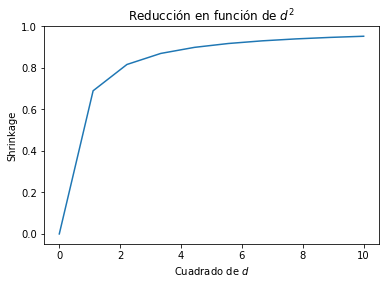

In [138]:
dvec = np.linspace(0,10,10)
lambda_vec = 0.5
shrink_fac = dvec/(dvec + lambda_vec)
plt.plot(dvec, shrink_fac)
plt.title(u'Reducción en función de $d^2$')
plt.xlabel('Cuadrado de $d$')
plt.ylabel('Shrinkage')

# ¿Cuándo es $d_i^2$ más grande o más chico?


* Recordemos que la para la matriz de covarianzas de $X$: $N^{-1}X'X$:

$$
X'X = VD^2V'
$$

* Y ahora notemos que $\mathbf{V}$ son los vectores propios de $X'X$:

$$
X'X V = VD^2V'V = VD^2
$$

Así que para el primer vector propio $\mathcal{v}_1$, el valor propio es $d_1^2$

$$
X'X v_1 = v_1 d_1^2
$$

> *La reducción es mayor con los vectores propios asociados a valores propios de $X'X$ más pequeños, es decir, aquellos que explican una menor varianza de $X$ o sus **componentes principales***.

Lo interesante es que esto implica que la reducción de los coeficientes es sobre los regresores $X_k$ que tienen *menor varianza*, y por lo tanto, los que mayor precisión tienen en la estimación.


#  Ridge Regression en la práctica

* En la práctica, estimar los coeficientes de Ridge es inmediato.


* Para cada valor de $\lambda$, se puede calcular directamente $\beta_{ridge}(\lambda)$


* Pero hay que recordar que debemos **centrar los regresores** y la variable dependiente primero.


* Con esto garantizamos que no penalizamos la constante.



In [139]:
unique_vec

[(283,), (399,), (387,), (9,), (68,), (16,), (2,), (2,), (2,), (2,), (2,)]

In [140]:
# Ridge regression
# Empecemos por estandarizar las variables.
# Nota: no tiene ningún sentido estandarizar variables dummy
prex_std = prexmat.copy()
# el siguiente es un ejemplo de un list comprehension de Python
unique_vec = [pd.Series(prex_std[:,i]).unique().shape for i in range(prex_std.shape[1])]  
for v in range(11):
    # Veamos si es una variable dummy:
    if unique_vec[v][0]>2:
        # Usemos reglas de broadcasting para simplificar
        prex_std[:,v] = (prex_std[:,v]- np.nanmean(prex_std[:,v],axis=0))/np.std(prex_std[:,v],axis=0)


In [141]:
# Ejemplo: lambda = 1
yy_std   = (saldo- np.nanmean(saldo,axis=0))/np.std(saldo,axis=0)

lambda_ridge = 1.0
prechol = np.dot(prex_std.T,prex_std) + lambda_ridge*np.eye(11)
xty    = np.dot(prex_std.T,yy_std)
beta_ridge = np.dot(np.linalg.inv(prechol),xty)
print(pd.DataFrame(beta_ridge, index= labs_x))

# guardémoslos para compararlos con otros que estimaremos a continuación
ridge_nuestros = pd.DataFrame(beta_ridge, index= labs_x, columns=['Nuestros'])


                   0
Rating      0.552284
Income     -0.590531
Limit       0.782154
Cards       0.045162
Age        -0.024094
Education  -0.005643
Own        -0.035353
Estudiante  0.887112
Casado     -0.041825
South      -0.066964
West       -0.043552


# Probemos que quedó bien, utilizando Scikit-Learn



* (Scikit-learn)[http://scikit-learn.org/stable/] es la librería de machine learning más utilizada por los usuarios de Python.


* Es fácil de usar, como veremos a continuación.


* Vamos a utilizar el método `Ridge` que utiliza un parámetro `alpha` que corresponde con nuestro $\lambda$

 ![caption](figures/scikitlearn.png)


In [142]:
# importemos el método
from sklearn.linear_model import Ridge
# llamemos el método, con alpha = 1.0
clf = Ridge(alpha=1.0)
# Ajustemos el modelo
clf.fit(prex_std, yy_std)
# imprimamos los coeficientes estimados
coef_scikit = pd.DataFrame(clf.coef_.T, index= labs_x, columns=['Scikit_Learn'])
pd.concat((coef_scikit, ridge_nuestros),axis=1)

,Scikit_Learn,Nuestros
Rating,0.538295,0.552284
Income,-0.590264,-0.590531
Limit,0.795075,0.782154
Cards,0.046150,0.045162
Age,-0.024028,-0.024094
Education,-0.006024,-0.005643
Own,-0.021810,-0.035353
Estudiante,0.897766,0.887112
Casado,-0.022184,-0.041825
South,-0.037986,-0.066964


<ipython-input-143-02165a1a2dc5>:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  beta_l   = np.linalg.lstsq(xlamb, xty)[0]


Text(0.5, 1.0, 'Resultados Ridge Regression')

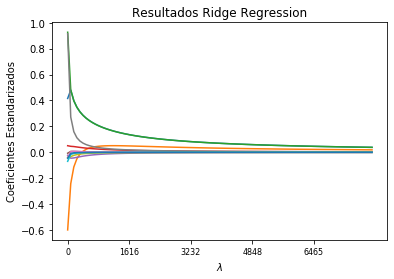

In [143]:
# Miremos cómo cambian los coeficientes con distintos lambdas
prex_con = prex_std.copy()

LL = 100
Llin = np.linspace(0,8000,LL)
Beta_ridge    = np.zeros((LL,11))
counter = 0
for lamb in Llin:
    # primero la matriz
    xlamb  = np.dot(prex_con.T,prex_con) + lamb*np.eye(11)
    # Ahora obtengamos la descomposición de cholesky:
    xty    = np.dot(prex_con.T,yy_std)
    beta_l   = np.linalg.lstsq(xlamb, xty)[0]
    Beta_ridge[counter,:] = beta_l.flatten()
    counter +=1

plt.plot(np.arange(LL),Beta_ridge)
plt.xticks(np.arange(100)[::20],np.round(Llin[::20],decimals=0).astype('int'), fontsize=8)
plt.xlabel('$\lambda$')
plt.ylabel('Coeficientes Estandarizados')
plt.title('Resultados Ridge Regression')


<ipython-input-144-fc85acf434e7>:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  beta_l   = np.linalg.lstsq(xlamb, xty)[0]


Text(0.5, 1.0, 'Resultados 10F CV')

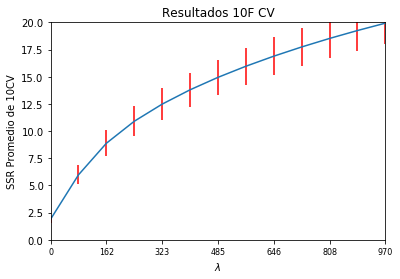

In [144]:
# cross-validation:
K =10
cv_grp = np.random.multinomial(1,[1.0/K]*K, N)
SSRCv  = np.zeros((LL,K))
for k in range(K):
    # asignación en grupos
    ind_train = cv_grp[:,k]==0
    nobs_train = ind_train.sum()
    ind_valid = cv_grp[:,k]==1
    # variables
    y_train   = yy_std[ind_train]
    y_valid   = yy_std[ind_valid]
    x_train   = prex_std[ind_train,:]
    x_valid   = prex_std[ind_valid,:]
    # listos para loop sobre los lambdas
    counter = 0
    for lamb in Llin:
        # primero la matriz
        xlamb  = np.dot(x_train.T,x_train) + lamb*np.eye(11)
        xty    = np.dot(x_train.T,y_train)
        # probemos con la función lstsq
        beta_l   = np.linalg.lstsq(xlamb, xty)[0]
        # ahora miremos el método usual
        beta_l   = np.dot(np.linalg.inv(xlamb), xty)
        # ssr en validación
        yhat_valid = np.dot(x_valid,beta_l.reshape((11,1)))
        y_diff     = y_valid - yhat_valid
        ssr        = np.dot(y_diff.T, y_diff)
        SSRCv[counter,k] = ssr[0,0]
        counter += 1
#pd.DataFrame(SSRCv.T).mean().loc[:10].plot()
meancv = pd.DataFrame(SSRCv.T).mean().values
semcv  = pd.DataFrame(SSRCv.T).sem().values
plt.plot(meancv)
plt.bar(np.arange(100),meancv, fc='w',ec='w', align='center', yerr=1.96*semcv, ecolor='r')
plt.xticks(np.arange(100)[::2],np.round(Llin[::2],decimals=0).astype('int'), fontsize=8)
plt.axis([0,12,0,20])
plt.xlabel('$\lambda$')
plt.ylabel('SSR Promedio de 10CV')
plt.title('Resultados 10F CV')

# Los resultados de 10F - CV sugieren que en este caso no es necesaria la regularización

# Más regularización: Lasso


* Lasso es otro método de regularización de los coeficientes, que utiliza una métrica distinta para penalizar coeficientes grandes.

$$
\beta_{lasso} = argmin_{\beta} (y - X\beta)'(y - X\beta) + \lambda \sum_j \left \vert \beta_j \right \vert
$$

* Desde un punto de vista de optimización, este es un problema de [programación cuadrática](https://en.wikipedia.org/wiki/Quadratic_programming), i.e. uno donde la función objetivo es cuadrática y está sujeto a restricciones lineales.

    * Una alternativa es utilizar una librería de optimización cuadrática como [`cvxopt`](http://cvxopt.org/).
    * Vamos a ver otros métodos para resolver el problema de optimización que son computacionalmente eficientes.


* Así que la mala noticia es que no hay una solución analítica, como si lo había en el caso del Ridge.


* La principal diferencia entre el Lasso y el Ridge es que el segundo reduce los coeficientes, y en el límite, cuando $\lambda \rightarrow \infty$, los coeficientes son cero.


* En Lasso, parte de la solución son algunos coeficientes exactamente iguales a cero, *para cualquier valor de $\lambda$*, así que es un método que permite hacer selección de variables.


# Comparación entre Lasso y Ridge

![caption](figures/lasso_ridge.png)

Figura 6.7 de [ISLR](http://www-bcf.usc.edu/~gareth/ISL/)

# ¿Cómo se encuentra la solución de Lasso?


* Vamos a utilizar un método de optimización que se llama [coordinate descent](https://www.cs.cmu.edu/~ggordon/10725-F12/slides/25-coord-desc.pdf).


* La idea es simple: queremos minimizar 
$$
f(\beta) = g(\beta) + \sum_i h_i(\beta_i)
$$


donde $g$ es una función convexa y diferenciable, y cada una de las $h_i$ es una función convexa, no necesariamente diferenciable.


* Para encontrar el mínimo podemos hacerlo *coordenada por coordenada*.


* En el caso de Lasso, el siguiente algoritmo funciona perfectamente (ver [acá, por ejemplo](http://web.stanford.edu/~hastie/TALKS/glmnet.pdf)).

# Pseudocódigo de Lasso vía Coordinate Descent


* Estandaricemos la matriz $X$ y $y$.


* Repita lo siguiente hasta que haya convergencia, para todo $k = 1, 2, \cdots, p, 1, 2, \cdots$:

> **Paso 1**: Obtenga los residuos excluyendo el regresor $k$: 
$$    
    r_{-k} = y - x_{-k}\beta_{-k}
$$
>     donde $x_{-k}$ excluye al regresor $k$, y $\beta_{-k}$ es la versión actual de los coeficientes excluyendo al $k-$ésimo.


> **Paso 2**: Obtenga el estimador de OLS simple para el regresor $k$:
    
$$    
    \beta^*_{k} = \frac{1}{N} r_{-k}'x_k = \frac{1}{N} \sum_j r_{-k,j}x_{jk}
$$


> **Paso 3**: Actualice $\beta_k$ por medio de *soft-thresholding*

$$
\begin{eqnarray*}
\beta_k &=& signo(\beta^*_{k})(\left \vert \beta^*_{k} \right \vert -\lambda)_{+} \\
\end{eqnarray*}
$$

>  donde $(x)_{+} = max(0,x)$ denota la [parte positiva](http://mathworld.wolfram.com/PositivePart.html)

# Veamos cómo se hace en Python

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 


data_cr = pd.read_csv('Files/Credit.csv')
nobs    = data_cr.shape[0]
saldo    = np.asarray(data_cr.Balance).reshape((nobs,1))
male     = np.asarray(data_cr.Own==' Yes').reshape((nobs,1))
student  = np.asarray(data_cr.Student=='Yes').reshape((nobs,1))
married  = np.asarray(data_cr.Married=='Yes').reshape((nobs,1))
eth_dum  = np.asarray(pd.get_dummies(data_cr.Region))[:,:-1]
oth_xmat = data_cr[[u'Income', u'Limit', u'Rating', u'Cards', u'Age', u'Education']]

labs_x = np.array([u'Income', u'Limit', u'Rating', u'Cards', u'Age', u'Education',
              'Hombre','Estudiante','Casado','South','West'])

prexmat  = np.concatenate((oth_xmat, male, student, married, eth_dum),axis=1)
#print prexmat.shape
nvar = prexmat.shape[1]
# I will start by standardizing/normalizing the matrix
prexmat_std = prexmat.copy()
ind_dum = np.array([pd.Series(prexmat[:,k]).unique().shape[0] for k in range(nvar)])
prexmat_std[:,ind_dum>2] -= prexmat_std[:,ind_dum>2].mean(axis=0).reshape((1,6))
# get the norms
norm_pxmat = np.array([np.linalg.norm(prexmat_std[:,ind_dum>2][:,k]) for k in range(np.sum(ind_dum>2))])
# ready to normalize
prexmat_std[:,ind_dum>2] /= prexmat_std[:,ind_dum>2].std(axis=0).reshape((1,6))

# also standardize y
yy_std = saldo.copy()
yy_std = yy_std - yy_std.mean()
yy_std = yy_std / yy_std.std()

In [146]:
# Fijemos un lambda:
lambda_vec = 0.1
# Inicialicemos el vector:
beta_actual = np.zeros((1,11))
dist = 1
counter = 0
maxiter = 10000
# loop externo: si no hay convergencia continúe
while dist>0.001: 
    #or counter<maxiter:
    # Loop interno: ciclo con los regresores
    beta_old = beta_actual.copy()
    for k in range(11):
        # Residuos parciales excluyendo k
        inc_k    = np.setdiff1d(np.arange(11),np.array([k]))
        xmat_k   = prexmat_std[:,inc_k]
        beta_k   = beta_actual[0,inc_k]
        resids_k = yy_std - np.dot(xmat_k, beta_k.reshape((10,1)))
        # OLS simple de k:
        beta_star_k = np.dot(resids_k.T,prexmat_std[:,k].reshape((nobs,1)))/(1.0*nobs)
        # Actualicemos beta_k
        beta_actual[0,k] = np.sign(beta_star_k)*np.max([0,np.abs(beta_star_k)-lambda_vec])
    # Actualicemos distancia:
    dist = np.max(np.abs(beta_actual-beta_old))
    counter +=1
print("total iteraciones: ", counter)
pd.DataFrame(beta_actual.T, index= labs_x.flatten(), columns = ['Nuestro'])

total iteraciones:  244


,Nuestro
Income,-0.111265
Limit,0.287465
Rating,0.565110
Cards,0.000000
Age,-0.000000
Education,0.000000
Hombre,0.000000
Estudiante,0.000000
Casado,-0.000000
South,-0.000000


# Cómo se haría en Scikit-learn?

In [147]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)
clf.fit(prexmat_std,yy_std)
pd.DataFrame(clf.coef_, index = labs_x, columns=['Scikit-Learn'])

,Scikit-Learn
Income,-0.109992
Limit,0.140338
Rating,0.710770
Cards,0.000000
Age,-0.000000
Education,0.000000
Hombre,0.000000
Estudiante,0.000000
Casado,-0.000000
South,-0.000000


In [148]:
# Miremos todo el path de lasso
L = 100
lambda_grid = np.linspace(0,0.6,L)
BetaLasso  = np.zeros((L,11))
for lamb in range(L):
    lambda_vec = lambda_grid[lamb]
    # Inicialicemos el vector:
    beta_actual = np.zeros((1,11))
    dist = 1
    counter = 0
    maxiter = 10000
    # loop externo: si no hay convergencia continúe
    while dist>0.001: 
        #or counter<maxiter:
        # Loop interno: ciclo con los regresores
        beta_old = beta_actual.copy()
        for k in range(11):
            # Residuos parciales excluyendo k
            inc_k    = np.setdiff1d(np.arange(11),np.array([k]))
            xmat_k   = prexmat_std[:,inc_k]
            beta_k   = beta_actual[0,inc_k]
            resids_k = yy_std - np.dot(xmat_k, beta_k.reshape((10,1)))
            # OLS simple de k:
            beta_star_k = np.dot(resids_k.T,prexmat_std[:,k].reshape((nobs,1)))/(1.0*nobs)
            # Actualicemos beta_k
            beta_actual[0,k] = np.sign(beta_star_k)*np.max([0,np.abs(beta_star_k)-lambda_vec])
        # Actualicemos distancia:
        dist = np.max(np.abs(beta_actual-beta_old))
        counter +=1
    # terminó, podemos actualizar
    BetaLasso[lamb,:] = beta_actual.reshape((1,11))

Text(0.5, 1.0, 'Path Completo de Lasso')

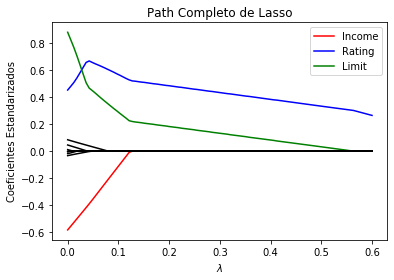

In [149]:
BetaLassoDF = pd.DataFrame(BetaLasso, columns= labs_x)
BetaLassoDF['lambda_lasso'] = lambda_grid
# Grafiquemos:
plt.plot(BetaLassoDF.lambda_lasso, BetaLassoDF.Income, label='Income', color='r')
plt.plot(BetaLassoDF.lambda_lasso, BetaLassoDF.Rating, label='Rating', color='b')
plt.plot(BetaLassoDF.lambda_lasso, BetaLassoDF.Limit,  label='Limit', color='g')
labs_exc = np.array([u'Cards', u'Age', u'Education',
              'Hombre','Estudiante','Casado','South','West'])
for k in range(8):
    plt.plot(BetaLassoDF.lambda_lasso, BetaLassoDF[labs_exc[k]], color='k')
plt.legend()
plt.xlabel('$\lambda$')
plt.ylabel('Coeficientes Estandarizados')
plt.title('Path Completo de Lasso')